# Template: Минимальная нейросеть PyTorch для **любой** бинарной классификации
**Формат:** весь код с пропусками `_____` + краткие подсказки.  
**Цель:** чтобы вы могли взять **любой CSV с Kaggle**, указать `TARGET_COL`, и получить:
- preprocessing (числа + категории)
- train/test split
- DataLoader
- простую MLP-модель
- train/eval loop + метрики
- подбор порога
- сохранение/загрузка модели

> Заполняйте пропуски `_____` сверху вниз, по порядку.


## 0) Что нужно от вашего датасета
1) CSV файл (например `train.csv`)  
2) Название целевой колонки: `TARGET_COL` (в ней 0/1 или True/False)  
3) Остальные колонки — признаки (числовые и/или категориальные)

Если у вас target не 0/1, приведите к 0/1:
- `df[TARGET_COL] = (df[TARGET_COL] == "Yes").astype(int)`
- `df[TARGET_COL] = df[TARGET_COL].astype(int)` (для True/False)


In [1]:
# ====== 0) Imports ======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("torch:", torch.__version__)
print("device:", device)

torch: 2.9.1+cpu
device: cpu


# 1) Загрузка данных

**Подсказка:** у Kaggle обычно `train.csv` лежит в папке проекта.  
Если вы в Colab, сначала загрузите файл в окружение или подключите Google Drive.

Заполните:
- `DATA_PATH` — путь к CSV
- `TARGET_COL` — название целевой колонки


In [6]:
# ====== 1) Load CSV ======
DATA_PATH = "global_population_risk.csv" 
# например: "train.csv" или "/content/train.csv"
TARGET_COL = "global_population_pressure_index"         # например: "Survived" / "target" / "is_fraud"

df = pd.read_csv(DATA_PATH)
print("shape:", df.shape)
df.head()

shape: (5796, 9)


,country,year,population,environmental_stress_score,ozone_risk_score,goods_supply_risk_score,climate_vulnerability_index,economic_resilience_score,global_population_pressure_index
0,Afghanistan,1990,37485284,31.9,37.9,36.5,56.0,23.8,44.7
1,Albania,1990,95073894,30.4,41.2,42.7,26.1,51.3,37.1
2,Algeria,1990,73212794,34.2,38.7,38.7,34.8,42.3,41.0
3,Argentina,1990,59885915,36.1,45.2,44.9,22.7,43.5,40.1
4,Australia,1990,15644063,53.0,47.8,29.8,33.6,72.0,37.9


## 1.1) Быстрая проверка target

**Подсказка:** target должен быть бинарным.  
Если target строковый/True-False — приведите к 0/1.


In [7]:
# ====== 1.1) Target sanity check ======
print(df[TARGET_COL].value_counts(dropna=False).head(10))

# Примеры преобразований (исправьте под свой датасет):
# df[TARGET_COL] = (df[TARGET_COL] == "_____").astype(int)
# df[TARGET_COL] = df[TARGET_COL].astype(int)

global_population_pressure_index
100.0    4600
39.3       13
38.4       12
39.7       12
37.7       11
45.6       11
39.6       10
37.4       10
41.1       10
42.7       10
Name: count, dtype: int64


# 2) Features/Target + train/test split

Заполните:
- `TEST_SIZE` (обычно 0.2 или 0.25)
- `RANDOM_STATE`


In [18]:
# ====== 2) Split ======
TEST_SIZE = 0.2
RANDOM_STATE = 42

X = df.drop(columns=[TARGET_COL, 'country'])
y = df[TARGET_COL].astype(np.float32).values  # (n,)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, 
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train mean:", y_train.mean(), "y_test mean:", y_test.mean())

X_train: (4636, 7) X_test: (1160, 7)
y_train mean: 90.00431 y_test mean: 88.93078


# 3) Определяем числовые и категориальные колонки

**Подсказка:** обычно:
- числовые: `int/float`
- категориальные: `object/category/bool`

Если у вас есть ID-колонка (например `PassengerId`), её можно удалить:
- `X = X.drop(columns=['PassengerId'])`


In [19]:
# ====== 3) Column lists ======
num_features = X_train.select_dtypes(include=["int64","int32","float64","float32"]).columns.tolist()
cat_features = X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()

print("num_features:", len(num_features))
print("cat_features:", len(cat_features))
print("Example num:", num_features[:10])
print("Example cat:", cat_features[:10])

num_features: 6
cat_features: 1
Example num: ['year', 'environmental_stress_score', 'ozone_risk_score', 'goods_supply_risk_score', 'climate_vulnerability_index', 'economic_resilience_score']
Example cat: ['population']


# 4) Preprocessing pipeline (важно против data leakage)

- Числовые: `SimpleImputer(median)` + `StandardScaler()`
- Категориальные: `SimpleImputer(most_frequent)` + `OneHotEncoder(handle_unknown='ignore')`

В результате получаем `X_train_proc`, `X_test_proc`.


In [23]:
# ====== 4) Preprocess with ColumnTransformer ======
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, num_features),
    ("cat", categorical_pipe, cat_features),
])

X_train_proc = preprocess.fit_transform(X_train)
X_test_proc  = preprocess.transform(X_test)

print("Processed train shape:", X_train_proc.shape)
print("Processed test  shape:", X_test_proc.shape)

Processed train shape: (4636, 4642)
Processed test  shape: (1160, 4642)


# 5) Torch tensors + DataLoader

`ColumnTransformer` часто возвращает sparse matrix. Для учебных датасетов можно `.toarray()`.

Заполните:
- `BATCH_SIZE`
- `TEST_BATCH`


In [25]:
# ====== 5) To torch ======
X_train_dense = X_train_proc.toarray() if hasattr(X_train_proc, "toarray") else X_train_proc
X_test_dense  = X_test_proc.toarray() if hasattr(X_test_proc, "toarray")  else X_test_proc

X_train_t = torch.tensor(X_train_dense, dtype=torch.float32)
X_test_t = torch.tensor(X_test_dense, dtype=torch.float32)

y_train_t = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
y_test_t = torch.tensor(y_test.reshape(-1,1), dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

BATCH_SIZE = 32
TEST_BATCH = 128

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=TEST_BATCH, shuffle=False)

xb, yb = next(iter(train_loader))
print("batch X:", xb.shape, xb.dtype)
print("batch y:", yb.shape, yb.dtype)

batch X: torch.Size([32, 4642]) torch.float32
batch y: torch.Size([32, 1]) torch.float32


# 6) Модель: минимальный MLP

Заполните:
- `HIDDEN` (например 64)
- `DROPOUT` (например 0.2 или 0.0)

`INPUT_DIM` берём автоматически из `X_train_t.shape[1]`.


In [26]:
# ====== 6) Model ======
INPUT_DIM = X_train_t.shape[1]
HIDDEN = 64
DROPOUT = 0.2

class KaggleBinaryMLP(nn.Module):
    def __init__(self, input_dim, hidden=64, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden)
        self.drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop(x)
        logits = self.fc2(x)
        return logits

model = KaggleBinaryMLP(INPUT_DIM, hidden=HIDDEN, dropout=DROPOUT).to(device)
print(model)
print("params:", sum(p.numel() for p in model.parameters()))

KaggleBinaryMLP(
  (fc1): Linear(in_features=4642, out_features=64, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)
params: 297217


# 7) Loss + Optimizer

Заполните:
- `LR`


In [28]:
# ====== 7) Loss & Optimizer ======
criterion = nn.BCEWithLogitsLoss()
LR = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("criterion:", type(criterion).__name__)
print("optimizer:", type(optimizer).__name__, "lr:", LR)

criterion: BCEWithLogitsLoss
optimizer: Adam lr: 0.001


# 8) Train/Eval loop

Заполните:
- `EPOCHS`


In [29]:
# ====== 8) Train/Eval ======
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for Xb, yb in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)

        logits = model(Xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Xb.size(0)

    return total_loss / len(loader.dataset)

@torch.no_grad()
def predict_probs(model, loader, device):
    model.eval()
    probs_all, y_all = [], []
    for Xb, yb in loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.sigmoid(logits).cpu().numpy().reshape(-1)
        probs_all.append(probs)
        y_all.append(yb.numpy().reshape(-1))
    return np.concatenate(probs_all), np.concatenate(y_all)

@torch.no_grad()
def evaluate(model, loader, device, threshold=0.5):
    probs, y_true = predict_probs(model, loader, device)
    y_true = y_true.astype(int)
    y_pred = (probs >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    try:
        auc = roc_auc_score(y_true, probs)
    except Exception:
        auc = None
    return acc, cm, auc, probs, y_true, y_pred

EPOCHS = 30
history = []
for epoch in range(1, EPOCHS+1):
    loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    acc, _, auc, *_ = evaluate(model, test_loader, device, threshold=0.5)
    history.append((epoch, loss, acc, auc if auc is not None else np.nan))

    if epoch % 5 == 0 or epoch == 1:
        print(f"epoch={epoch:03d} loss={loss:.4f} acc={acc:.4f} auc={auc}")

hist = pd.DataFrame(history, columns=["epoch","loss","acc","auc"])
hist.tail()

epoch=001 loss=-124.9729 acc=0.0000 auc=None
epoch=005 loss=-8151.6986 acc=0.0000 auc=None
epoch=010 loss=-34407.3019 acc=0.0000 auc=None
epoch=015 loss=-75109.1195 acc=0.0000 auc=None
epoch=020 loss=-128119.2357 acc=0.0000 auc=None
epoch=025 loss=-191722.9593 acc=0.0000 auc=None
epoch=030 loss=-265095.7036 acc=0.0000 auc=None


,epoch,loss,acc,auc
25,26,-205537.080363,0.0,NaN
26,27,-220010.952397,0.0,NaN
27,28,-234729.053683,0.0,NaN
28,29,-250230.395788,0.0,NaN
29,30,-265095.703624,0.0,NaN


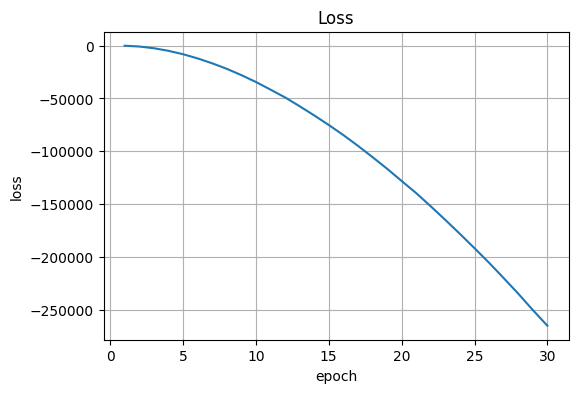

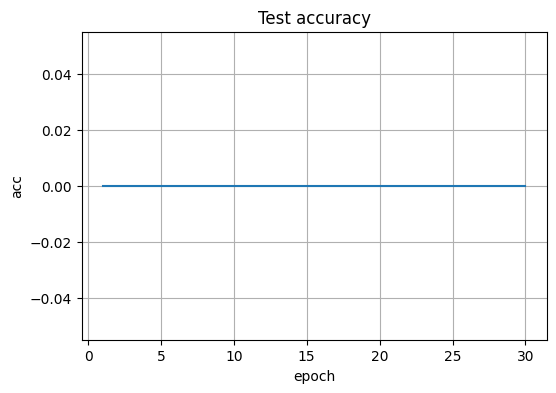

In [30]:
# Графики
plt.figure(figsize=(6,4))
plt.plot(hist["epoch"], hist["loss"])
plt.title("Loss")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist["epoch"], hist["acc"])
plt.title("Test accuracy")
plt.xlabel("epoch"); plt.ylabel("acc")
plt.grid(True); plt.show()

# 9) Подбор порога (threshold)

Заполните `BEST_THR`.


In [32]:
# ====== 9) Threshold ======
for thr in [0.3, 0.5, 0.7]:
    acc, cm, auc, probs, y_true, y_pred = evaluate(model, test_loader, device, threshold=thr)
    print(f"thr={thr}: acc={acc:.4f} auc={auc}")
    print("CM:\n", cm)
    print("-"*40)

BEST_THR = 0.5
acc, cm, auc, probs, y_true, y_pred = evaluate(model, test_loader, device, threshold=BEST_THR)
print("BEST_THR:", BEST_THR, "acc:", acc, "auc:", auc)
print("CM:\n", cm)
print(classification_report(y_true, y_pred, digits=3))

thr=0.3: acc=0.0000 auc=None
CM:
 [[  0   0   0 ...   0   0   0]
 [  1   0   0 ...   0   0   0]
 [  2   0   0 ...   0   0   0]
 ...
 [  2   0   0 ...   0   0   0]
 [  2   0   0 ...   0   0   0]
 [896   0   0 ...   0   0   0]]
----------------------------------------
thr=0.5: acc=0.0000 auc=None
CM:
 [[  0   0   0 ...   0   0   0]
 [  1   0   0 ...   0   0   0]
 [  2   0   0 ...   0   0   0]
 ...
 [  2   0   0 ...   0   0   0]
 [  2   0   0 ...   0   0   0]
 [896   0   0 ...   0   0   0]]
----------------------------------------
thr=0.7: acc=0.0000 auc=None
CM:
 [[  0   0   0 ...   0   0   0]
 [  1   0   0 ...   0   0   0]
 [  2   0   0 ...   0   0   0]
 ...
 [  2   0   0 ...   0   0   0]
 [  2   0   0 ...   0   0   0]
 [896   0   0 ...   0   0   0]]
----------------------------------------
BEST_THR: 0.5 acc: 0.0 auc: None
CM:
 [[  0   0   0 ...   0   0   0]
 [  1   0   0 ...   0   0   0]
 [  2   0   0 ...   0   0   0]
 ...
 [  2   0   0 ...   0   0   0]
 [  2   0   0 ...   0   0   0]
 

C:\Users\nikak\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\nikak\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\nikak\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# 10) Сохранение и загрузка (model + preprocess)

Сохраняем:
- preprocess через joblib
- веса модели через torch.save(state_dict)


In [36]:
# ====== 10) Save/Load ======
import joblib

PREPROCESS_PATH = "preprocess.joblib"
MODEL_PATH = "my_kaggle_dict.pt"

joblib.dump(preprocess, PREPROCESS_PATH)
torch.save(model.state_dict(), MODEL_PATH)

print("Saved preprocess:", PREPROCESS_PATH)
print("Saved model     :", MODEL_PATH)

# ---- Load example ----
preprocess2 = joblib.load(PREPROCESS_PATH)

model2 = KaggleBinaryMLP(INPUT_DIM, hidden=HIDDEN, dropout=DROPOUT).to(device)
model2.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model2.eval()

acc2, cm2, auc2, *_ = evaluate(model2, test_loader, device, threshold=BEST_THR)
print("Loaded acc:", acc2, "auc:", auc2)
print("Loaded CM:", cm2)


Saved preprocess: preprocess.joblib
Saved model     : my_kaggle_dict.pt
Loaded acc: 0.0 auc: None
Loaded CM: [[  0   0   0 ...   0   0   0]
 [  1   0   0 ...   0   0   0]
 [  2   0   0 ...   0   0   0]
 ...
 [  2   0   0 ...   0   0   0]
 [  2   0   0 ...   0   0   0]
 [896   0   0 ...   0   0   0]]


# 11) Inference / Submission (по желанию)

Если у Kaggle есть `test.csv` без target:
1) читаем `test.csv`
2) preprocess.transform
3) sigmoid → prob
4) threshold → 0/1
5) сохраняем submission.csv

Заполните:
- `TEST_PATH`
- `ID_COL`


In [39]:
# ====== 11) Inference / Submission ======
TEST_PATH = "global_population_risk.csv"          # "test.csv"
ID_COL = "country"             # "id" / "PassengerId" / ...

SUBMISSION_PATH = "submission.csv"

df_test = pd.read_csv(TEST_PATH)

# Если ID_COL нет:
# df_test[ID_COL] = np.arange(len(df_test))

X_new = df_test.copy()

X_new_proc = preprocess2.transform(X_new)
X_new_dense = X_new_proc.toarray() if hasattr(X_new_proc, "toarray") else X_new_proc
X_new_t = torch.tensor(X_new_dense, dtype=torch.float32).to(device)

with torch.no_grad():
    logits = model2(X_new_t)
    probs = torch.sigmoid(logits).cpu().numpy().reshape(-1)

pred = (probs >= BEST_THR).astype(int)  # или probs, если Kaggle просит вероятность

submission = pd.DataFrame({
    ID_COL: df_test[ID_COL],
    TARGET_COL: pred
})

submission.to_csv(SUBMISSION_PATH, index=False)
print("Saved submission:", SUBMISSION_PATH)
submission.head()

Saved submission: submission.csv


,country,global_population_pressure_index
0,Afghanistan,1
1,Albania,1
2,Algeria,1
3,Argentina,1
4,Australia,1


---
## Чеклист (если что-то падает)
- Проверь `TARGET_COL` и что он бинарный.
- Если есть `NaN` в target — сначала разберись с ними (обычно такие строки удаляют).
- Если много категорий и OHE огромный: уменьшай `HIDDEN`, увеличивай `BATCH_SIZE`, или начни с меньшего набора фич.
- Если дисбаланс: подбирай `BEST_THR`, смотри `classification_report`, и можно добавить `pos_weight`.
